In [ ]:
%cd /content/drive/MyDrive/CV02/polyp_dataset_project09

/content/drive/MyDrive/CV02/polyp_dataset_project09


In [ ]:
# IMPORT LIBRARIES
import os
import random
import json

import numpy as np
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import functional as F
from torchvision.models.segmentation import deeplabv3_resnet101
from torch.optim.lr_scheduler import ReduceLROnPlateau

try:
    from torchmetrics import Dice
except ModuleNotFoundError:
    !pip install -q torchmetrics
    from torchmetrics import Dice


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set all relevant seeds to 2024
set_seed(2024)

In [ ]:
# CONFIGURATION

# CONSTANTS
RANDOM_STATE  = 2024
BATCH_SIZE    = 128
NUM_WORKERS   = 8
PIN_MEMORY    = True
TEST_SIZE     = 0.2
LEARNING_RATE = 0.001
NUM_EPOCHS    = 100
IMAGE_SIZE    = 128

# PATHS
ROOT = '/content/drive/MyDrive/CV02/polyp_dataset_project09'
BEST_MODEL_PATH = os.path.join(ROOT, 'models', 'unet_best_model.pth')
IMAGE_DIR = os.path.join(ROOT, 'images')
OUTPUT_DIR = os.path.join(ROOT, 'seg_output')

TRAIN_JSON = os.path.join(ROOT, 'polyp_train.json')
VAL_JSON = os.path.join(ROOT, 'polyp_valid.json')
TEST_JSON = os.path.join(ROOT, 'polyp_test.json')

# VARIABLES
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device...')

Using cuda device...


In [ ]:
def load_json(path):
    data = None
    with open(path, 'r') as f:
        data = json.load(f)
    return data

polyp_test = load_json(TEST_JSON)['images']
print(f'{len(polyp_test)} test images.')

400 test images.


In [ ]:
image_paths = [item['image_path'] for item in polyp_test]
image_paths[0]

'./images/NeoPolyp-Small/00fd197cd955fa095f978455cef3593c.jpg'

In [ ]:
# polyp_dataset_names = os.listdir(IMAGE_DIR)

# # Get all image paths
# image_paths = {}
# for ds_name in polyp_dataset_names:
#     ds_path = os.path.join(IMAGE_DIR, ds_name)
#     ds_image_paths = [os.path.join(ds_path, fn) for fn in os.listdir(ds_path)]
#     image_paths[ds_name] = (ds_image_paths)

#     print(f'{ds_name}: {len(ds_image_paths)} real polyp images.')
#     print(image_paths[ds_name][0])
#     print('')

In [ ]:
def convert_to_mask_path(image_path):
    mask_path = image_path.replace('/images/', '/images-mask/')
    if os.path.isfile(mask_path):
        return mask_path
    else:
        raise ValueError(f'Mask path not found. {mask_path}')

sample_image_path = image_paths[0]
print(sample_image_path)
print(convert_to_mask_path(sample_image_path))

./images/NeoPolyp-Small/00fd197cd955fa095f978455cef3593c.jpg
./images-mask/NeoPolyp-Small/00fd197cd955fa095f978455cef3593c.jpg


## Dataset

In [ ]:
class GeneratedPoLypDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = sorted(image_paths)
        self.len = len(self.image_paths)
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        # Load image
        image_path = self.image_paths[idx]
        image = read_image(image_path)

        # Load mask
        mask_path = convert_to_mask_path(image_path)
        mask = read_image(mask_path)

        # Resize image and mask
        image = F.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        mask  = F.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))

        # The generated image has 4 channels
        # 3 first channels are RGB, the last is a black background
        # Return only 1 channel of image
        if image.shape[0] > 3:
            image = image[:3,...]

        # The generated mask has 4 channels
        # The first 3 channels are binary mask, the last is a black background
        # Return only 1 channel of mask
        if mask.shape[0] > 1:
            mask = mask[0,...]

        # Normalize image and mask
        #image = self.normalize(image)
        mask  = mask / 255.0

        return image.float(), mask.int(), image_path

Image shape: torch.Size([3, 128, 128])
Image min value: 0.0
Image max value: 1.0
Mask shape: torch.Size([128, 128])
Mask min value: 0
Mask max value: 1
Image path: ./images/NeoPolyp-Small/2315b4c10e2b0e33fa12bfcd6da15fc6.jpg


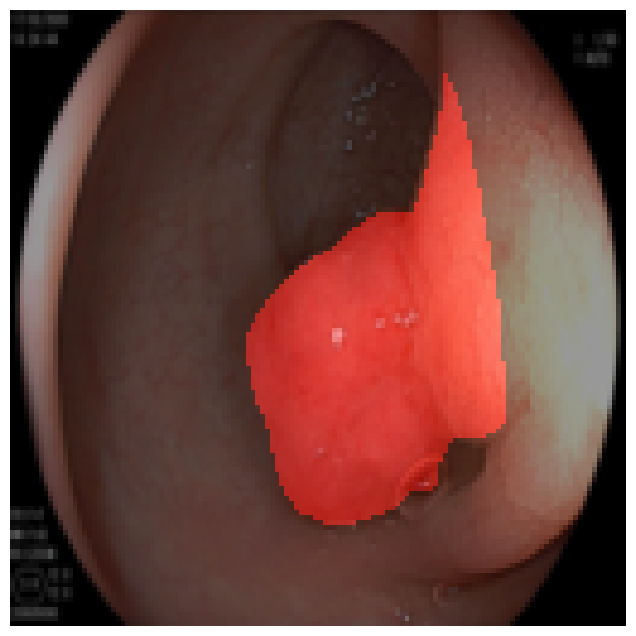

In [ ]:
def plot_image_with_mask(image, mask):
    image = image.permute(1, 2, 0)
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the image
    ax.imshow(image)

    # Create a mask where mask > 0
    mask_rgb = np.zeros_like(image)  # Initialize an array of zeros with the same shape as the image
    mask_rgb[mask > 0] = [1, 0, 0]  # Set mask values greater than 0 to red [R, G, B]

    # Overlay the mask
    ax.imshow(mask_rgb, alpha=0.4)  # Red mask overlay

    ax.axis('off')
    plt.show()


train_dataset = GeneratedPoLypDataset(image_paths)
image, mask, image_path = train_dataset[-1]
image = image / 255.0
print(f'Image shape: {image.shape}')
print(f'Image min value: {image.min().item()}')
print(f'Image max value: {image.max().item()}')
print(f'Mask shape: {mask.shape}')
print(f'Mask min value: {mask.min().item()}')
print(f'Mask max value: {mask.max().item()}')
print(f'Image path: {image_path}')


# Plot image with mask overlay
plot_image_with_mask(image, mask)

## Train

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets):
        smooth = 1e-6
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    dice = Dice().to(device)

    for images, masks, _ in tqdm(dataloader, desc="Training", leave=False):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs.squeeze(), masks.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        dice.update(outputs, masks)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_dice = dice.compute()

    return epoch_loss, epoch_dice

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    dice = Dice().to(device)

    with torch.no_grad():
        for images, masks, _ in tqdm(dataloader, desc="Validation", leave=False):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs.squeeze(), masks.float())

            running_loss += loss.item()
            dice.update(outputs, masks)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_dice = dice.compute()

    return epoch_loss, epoch_dice

def do_one_epoch(
        model,
        train_dataloader,
        val_dataloader,
        optimizer,
        criterion,
        device,
        scheduler=None):

    # Train
    epoch_train_loss, epoch_train_dice = train_epoch(
        model=model,
        dataloader=train_dataloader,
        optimizer=optimizer,
        criterion=criterion,
        device=device
    )
    print(f'Train loss: {epoch_train_loss:.4f}, train dice: {epoch_train_dice:.4f}')

    # Validate
    epoch_val_loss, epoch_val_dice = validate_epoch(
        model=model,
        dataloader=val_dataloader,
        criterion=criterion,
        device=device,
    )
    print(f'Val loss  : {epoch_val_loss:.4f}, val dice: {epoch_val_dice:.4f}')

    # Update learning rate scheduler
    if scheduler is not None:
        scheduler.step(epoch_val_loss)

    # Return losses and metrics of this epoch
    return {
        'epoch_train_loss': epoch_train_loss,
        'epoch_train_dice': epoch_train_dice,
        'epoch_val_loss'  : epoch_val_loss,
        'epoch_val_dice'  : epoch_val_dice,
    }

## Model

In [ ]:
# model

class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm):
        super(unetConv2, self).__init__()

        if is_batchnorm:
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_size, out_size, 3, 1, 1),
                nn.BatchNorm2d(out_size),
                nn.ReLU(),
            )
            self.conv2 = nn.Sequential(
                nn.Conv2d(out_size, out_size, 3, 1, 1),
                nn.BatchNorm2d(out_size),
                nn.ReLU(),
            )
        else:
            self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, 3, 1, 1), nn.ReLU())
            self.conv2 = nn.Sequential(
                nn.Conv2d(out_size, out_size, 3, 1, 1), nn.ReLU()
            )

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        #print (outputs.shape)
        outputs = self.conv2(outputs)
        #print (outputs.shape)
        return outputs

class unetUp(nn.Module):
    def __init__(self, in_size, out_size, is_deconv, is_batchnorm):
        super(unetUp, self).__init__()
        self.conv = unetConv2(in_size, out_size, is_batchnorm)

        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, inputs1, inputs2):
        outputs2 = self.up(inputs2)
        offset = outputs2.size()[2] - inputs1.size()[2]
        padding = 2 * [offset // 2, offset // 2]
        outputs1 = F.pad(inputs1, padding)

        return self.conv(torch.cat([outputs1, outputs2], 1))

class UnetSegmentationModel(nn.Module):
    def __init__(self,in_channels, num_classes):
        super().__init__()

        self.in_channels=in_channels
        self.num_classes=num_classes

        #Some config for UNET model
        self.is_batchnorm = True
        self.feature_scale=2
        self.is_deconv = True #Sử dụng Deconvolution hay Upsample layer
        filters = [64, 128, 256, 512, 1024]
        filters = [int(x / self.feature_scale) for x in filters]

        #DEFINE UNET MODEL
        # downsampling
        self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.center = unetConv2(filters[3], filters[4], self.is_batchnorm)

        # upsampling
        self.up_concat4 = unetUp(filters[4], filters[3], self.is_deconv, self.is_batchnorm)
        self.up_concat3 = unetUp(filters[3], filters[2], self.is_deconv, self.is_batchnorm)
        self.up_concat2 = unetUp(filters[2], filters[1], self.is_deconv, self.is_batchnorm)
        self.up_concat1 = unetUp(filters[1], filters[0], self.is_deconv, self.is_batchnorm)

        # final conv (without any concat)
        self.final = nn.Conv2d(filters[0], self.num_classes, 1)

    def forward(self, inputs):
        conv1 = self.conv1(inputs)
        maxpool1 = self.maxpool1(conv1)

        conv2 = self.conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)

        conv3 = self.conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)

        conv4 = self.conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)

        center = self.center(maxpool4)

        up4 = self.up_concat4(conv4, center)
        up3 = self.up_concat3(conv3, up4)
        up2 = self.up_concat2(conv2, up3)
        up1 = self.up_concat1(conv1, up2)

        final = nn.functional.sigmoid(self.final(up1))

        return final

In [ ]:
model = UnetSegmentationModel(in_channels=3, num_classes=1)
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.to(device)

# Count the number of learnable parameters
learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of learnable parameters: {learnable_params}")

Number of learnable parameters: 7765985


## Test


In [ ]:
def test_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    dice = Dice().to(device)

    preds = {}

    with torch.no_grad():
        for images, masks, image_path in tqdm(dataloader, desc="Test", leave=False):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs.squeeze(), masks.float())

            # Save predicted segmentations
            preds[image_path] = outputs.detach().cpu().numpy()

            running_loss += loss.item()
            dice.update(outputs, masks)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_dice = dice.compute()

    return epoch_loss, epoch_dice, preds

def test(image_paths, model, device):
    # Dataset
    test_dataset = GeneratedPoLypDataset(image_paths)

    # Dataloader
    test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )
    print(f'{len(test_dataset)} test images.')

    # Loss function
    criterion = DiceLoss()

    # Loss and metric
    test_loss, test_dice, preds = test_epoch(
        model=model,
        dataloader=test_dataloader,
        criterion=criterion,
        device=device,
    )

    print(f'Test loss: {test_loss:.4f}')
    print(f'Test dice: {test_dice:.4f}')


# ---------- TEST ALL DATASETS ----------
test(image_paths, model, device)

400 test images.


Test loss: 0.0031
Test dice: 0.7058


## Visualize prediction

In [ ]:
def tensor_to_numpy(tensor):
    return tensor.detach().cpu().numpy()


def visualize(image_paths, model, device, batch_size=8):
    model.eval()

    # Dataset
    test_dataset = GeneratedPoLypDataset(image_paths)

    # Dataloader
    test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    # Load a single batch
    data_iter = iter(test_dataloader)
    images, true_segmentations, _ = next(data_iter)

    # Move to the appropriate device, e.g., GPU if available
    images = images.to(device)

    # Get the model's predictions
    with torch.no_grad():
        predicted_segmentations = model(images)

        images_np = tensor_to_numpy(images)
        true_segmentations_np = tensor_to_numpy(true_segmentations)
        predicted_segmentations_np = tensor_to_numpy(predicted_segmentations)

        # Calculate Dice scores
        dice = Dice()
        dice_scores = []
        for i in range(images_np.shape[0]):
            dice_score = dice(
                torch.tensor(predicted_segmentations_np[i]),
                torch.tensor(true_segmentations_np[i])
            )
            dice_scores.append(dice_score.item())

        # Plotting the batch of images
        fig, axes = plt.subplots(8, 3, figsize=(15, 40))

        for i in range(8):
            # Original Image
            org_img = images_np[i].transpose(1, 2, 0)
            org_img /= 255
            ax = axes[i, 0]
            ax.imshow(org_img)  # Assuming image is in CHW format
            ax.set_title('Original Image')
            ax.axis('off')

            # True Segmentation
            gt_seg = true_segmentations_np[i]
            ax = axes[i, 1]
            ax.imshow(gt_seg, cmap='gray')  # Assuming segmentation mask is grayscale
            ax.set_title('True Segmentation')
            ax.axis('off')

            # Predicted Segmentation
            pred_seg = predicted_segmentations_np[i].squeeze()
            ax = axes[i, 2]
            ax.imshow(pred_seg, cmap='gray')  # Assuming segmentation mask is grayscale
            ax.set_title(f'Predicted Segmentation\nDice: {dice_scores[i]:.4f}')
            ax.axis('off')

        plt.tight_layout()
        plt.show()

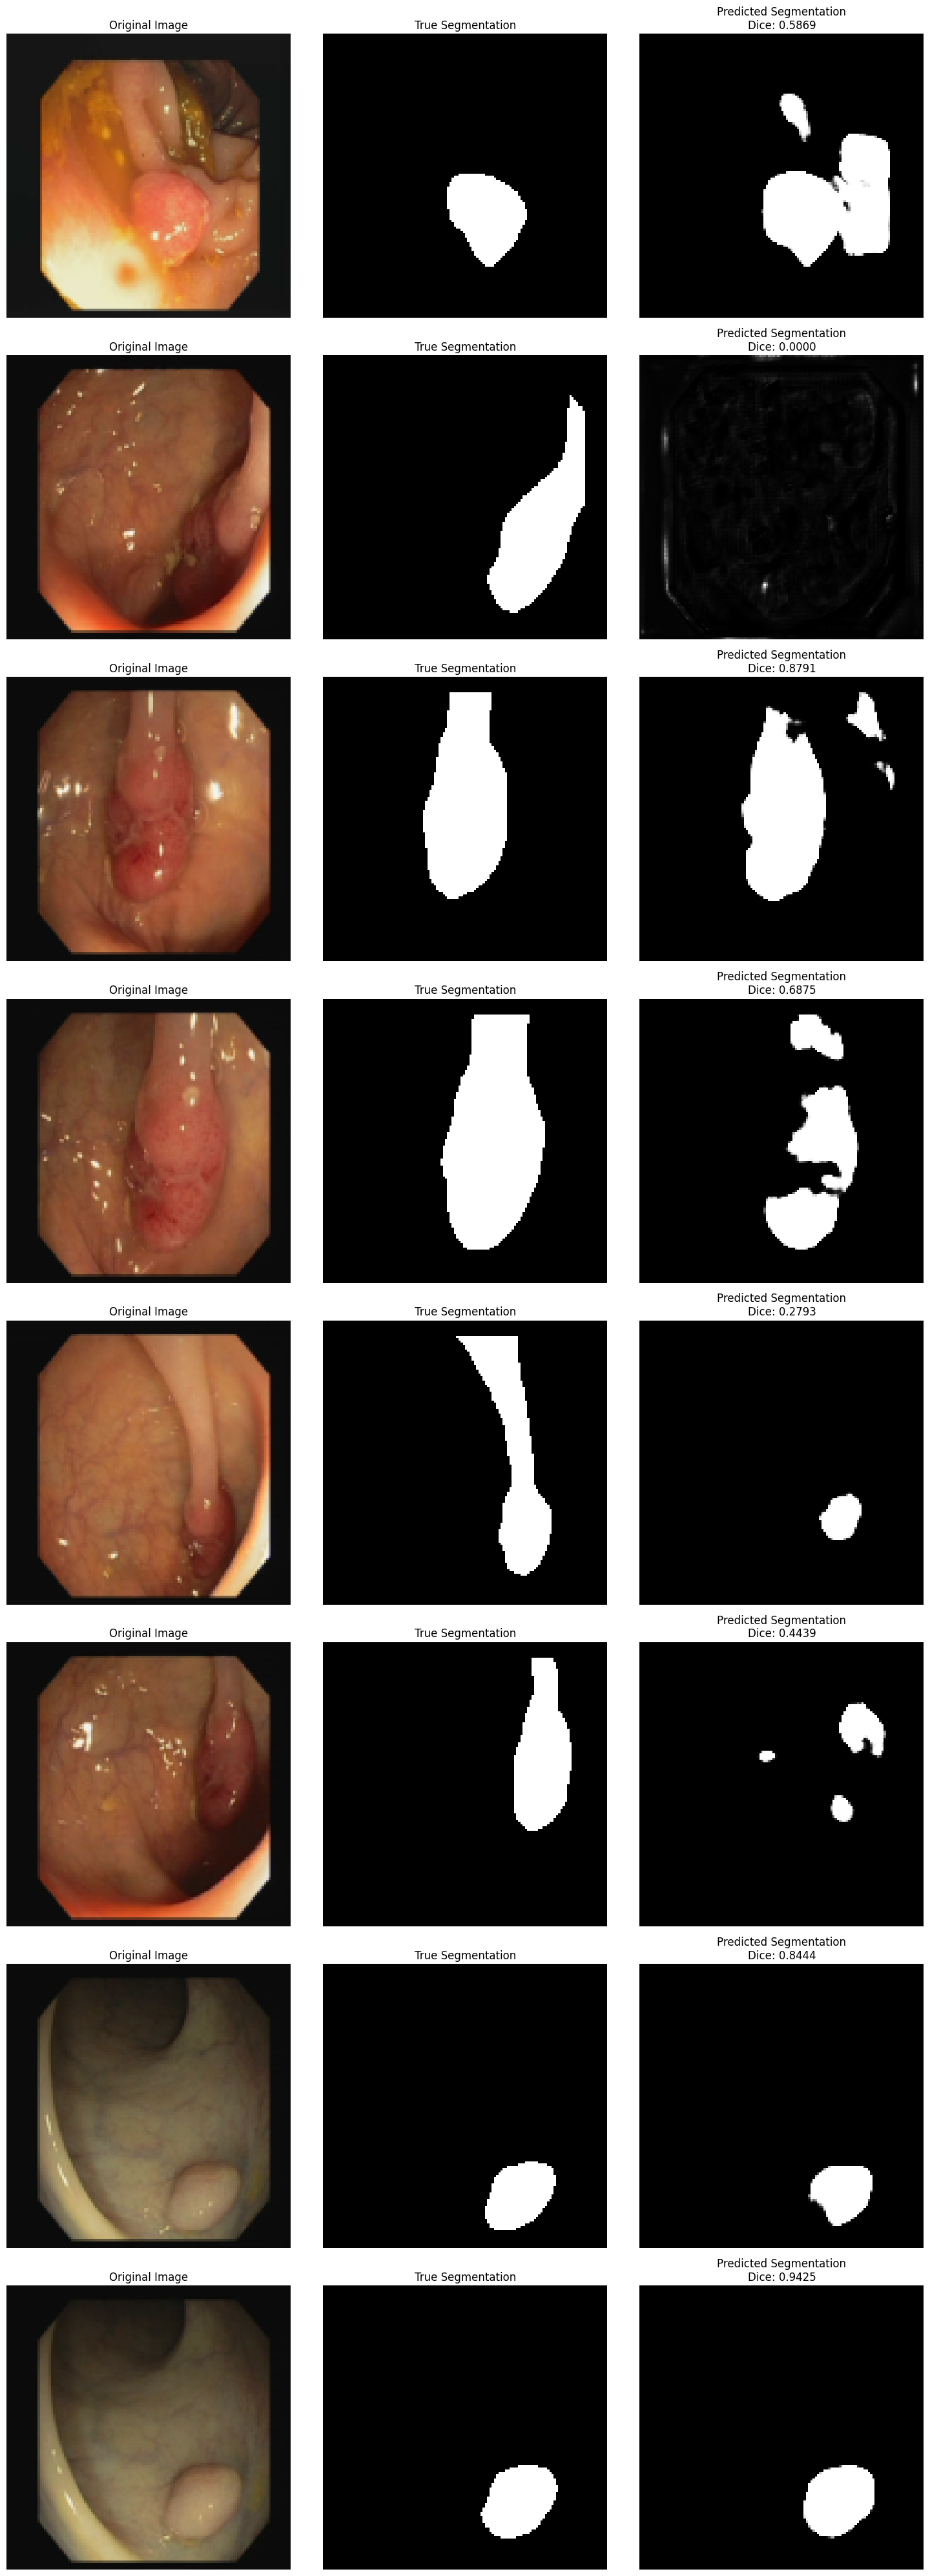

In [ ]:
visualize(image_paths=image_paths, model=model, device=device)